<font size="5">CSC 692 - Advanced Robotic Algorithms ---- </font>
<br>
<font size="3">Homework 4 ----- </font>
<br>
<font size="3">Sherwyn Braganza, Sharvil Pai Raiker</font>
<br>

<strong>Environment: Assume your domain is the x-y plane. To start, you have the obstacle: Circle with radius = 4 and center = (11,11).
1) Using one of the planners, find (approximately) the shortest path from (9,15) to (15,9).   Plot the domain, the obstacle and the path. <strong/>
    
I used my a_star algorithm from the previous lab to find a path from start to the end points. I also have a variable called precision that controls how precise I want to be in my pathing - how many sub points each integer traversal is divided into; by default it is set to 0.1 which implies that there are 10 points between x = 10 and x = 11, vis-a-vis 10, 10.1, 10.2 and so on.

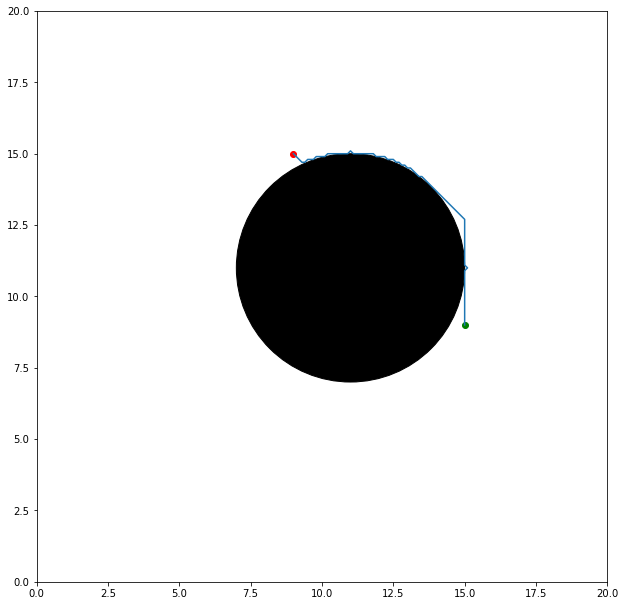

In [1]:
import numpy as np
import math
from a_star_alg import a_star
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches

# Change the grid positions to -1 where the intersect with the obstacles
def add_obstacles_to_grid(obstacles: list, grid: np.matrix, obstacle_sub_grid):
    for obs in obstacles:
        for i in range(0, rows):
            for j in range(0, cols):
                if ((i*precision-obs[0])/obs[2]) ** 2 + ((j*precision-obs[1])/obs[3])**2 - 1 <= 0:
                    grid[i, j] = -1
                    obstacle_sub_grid.append((i,j))
                    
precision = 0.1 # How subdivided each interger interval is
bias = 0, 0 # The most -ve possible value

rows = int(20 / precision)
cols = int(20 / precision)
start = 9,15
end = 15,9
resolved_start = (int(9 / precision), int(15 / precision))
resolved_end = (int(15 / precision), int(9 / precision))

path = []
obstacles = []

# Grid Representation Convention
# obstacles are -1
# free space is 0
# start is 7
# end is 8
# path is 9


grid = np.zeros((cols, rows), dtype=int)
# represented in the 4 tuple form (xcood,ycood,radiusx,radiusy)
obstacles.append((11, 11, 4, 4))
obstacle_sub_grid = []
add_obstacles_to_grid(obstacles, grid, obstacle_sub_grid)
                                             
path = a_star(resolved_start, resolved_end, grid)  # import a-star path planner from last homework

# extract found path
if path is not None:
    for i in path:
        grid[i[0], i[1]] = 9
    grid[resolved_start] = 7
    grid[resolved_end] = 8

path.reverse()
############################## Plotting Section ##############################
x_path = []
y_path = []
obstacle_figs = []

for x in path:
    x_path.append(x[0]*precision)
    y_path.append(x[1]*precision)

fig, ax = plt.subplots()

obstacle_figs.append(plt.Circle((11, 11), 4, color='black'))

# plot the path
plt.plot(x_path, y_path)
plt.scatter(start[0], start[1], color='red')  # mark start with red
plt.scatter(end[0], end[1], color='green')  # mark end with green

# add obstacles
for x in obstacle_figs:
    ax.add_patch(x)

# set plot parameters
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))
ax.set_aspect(1)
fig.set_size_inches(18.5, 10.5)

plt.show()

# remove path points that are unreachable by the arm
for i in path:
    if math.sqrt((i[0]*precision) ** 2 + (i[1]*precision) ** 2) > 20:
        path.remove(i)



<strong>2) Assume that the path is the end-effector of a two link manipulator with arm lengths a1 = 10 and a2 = 10. The base of the arm is (0,0). Feed 5 to 15 of the path points into the inverse kinematics. Plot the arms, path, and obstacle on the domain. You may want to only plot 5. Pick representative plots to show what the arm is doing? Are there any issues? <strong/>

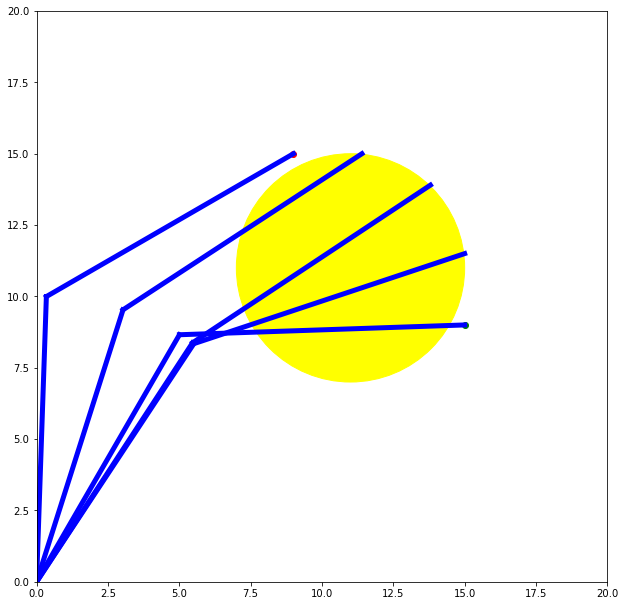

In [2]:
# end position calc for planar manip 
def fk(a, n):
    position = (0,0)
    for i in range(0, len(a) if len(a) < len(n) else len (n)):
        max_angle_sum = n[0]
        for j in range(1,i+1):
            max_angle_sum += n[j]
        position = (position[0] + a[i]*math.cos(max_angle_sum), position[1] + a[i]*math.sin(max_angle_sum))
    return position

# jacobian calculator for n link manip
def jacobian(a, n):
    max_idx = len(a) - 1
    matrix = np.zeros((2, len(a)), dtype=float)

    max_angle_sum = 0
    for i in range(0, len(a)):
        max_angle_sum += n[i]

    matrix[0, max_idx] = -a[max_idx] * math.sin(max_angle_sum)
    matrix[1, max_idx] = +a[max_idx] * math.cos(max_angle_sum)

    for i in range(-2, -len(a) - 1, -1):
        max_angle_sum = 0
        for j in range(i, -len(a) - 1, -1):
            max_angle_sum += n[j]
        matrix[0, i] = -a[i] * math.sin(max_angle_sum) + matrix[0, i + 1]
        matrix[1, i] = +a[i] * math.cos(max_angle_sum) + matrix[1, i + 1]

    return matrix
    
# def ik_two(pos, a, n):
#     delta,k = 0.1, 0
#     xc,yc = fk(a, n)
#     euclidean = math.sqrt((pos[0]-xc)**2 + (pos[1]-yc)**2)

#     while euclidean > .1:
#         s = delta*math.sqrt((pos[0]-xc)**2 + (pos[1]-yc)**2)
#         u = np.matrix([[s*(pos[0] - xc)], [s*(pos[1] - yc)]])
#         J = jacobian_two(a,n)
#         n = (np.matrix(n).reshape(2,1) + np.linalg.pinv(J)*u)%(2*math.pi)
#         xc,yc = fk(a,n)
#         euclidean = math.sqrt((pos[0]-xc)**2 + (pos[1]-yc)**2)
#         k +=1

#     return n

# Closed Form IK Solution
def ik_two(pos:tuple, a:list, n:list) -> list:
    x, y = pos
    D = (x**2 + y**2 - a[0]**2 - a[1]**2)/(2*a[0]*a[1])
    try:
        if n[1] == math.atan(-(math.sqrt(1-D**2))/D):
            n[1] = math.atan((math.sqrt(1-D**2))/D)
        else:
            n[1] = math.atan(-(math.sqrt(1-D**2))/D)
            
        n[0] = math.atan(y/x) - math.atan(a[1]*math.sin(n[1])/(a[0] + a[1]*math.cos(n[1])))
    except:
        print("Error @:",x,y)
    return n


############################## Plotting Section ##############################
obstacle_figs=[]
x_path = []
y_path = []

for i in range(0, len(path)-int(len(path)/4), int(len(path)/4)):
    x_path.append(path[i][0]*precision)
    y_path.append(path[i][1]*precision)

x_path.append(end[0])
y_path.append(end[1])

x_midpoint = [0] * len(x_path)
y_midpoint = [0] * len(y_path)

for i in range (0,len(x_path)):
    x_midpoint[i], y_midpoint[i] = fk([10], [ik_two((x_path[i],y_path[i]),[10,10],[0,0])[0]])

# plot the path on multiple figures
# for i in range(0, len(x_path)):
#     plt.figure(i)
#     obstacle_figs.append(plt.Circle(( 11 , 11 ), 4, color='yellow'))
#     fig, ax = plt.subplots()
#     fig.set_size_inches(18.5, 10.5)
#     ax.set_xlim((0, 20))
#     ax.set_ylim((0, 20))
#     ax.set_aspect(1)
#     ax.add_patch(obstacle_figs[i])
#     plt.plot([0, x_midpoint[i]],[0, y_midpoint[i]], linewidth=5.0)
#     plt.plot([x_midpoint[i], x_path[i]],[y_midpoint[i], y_path[i]], linewidth=5.0)
#     plt.scatter(start[0],start[1], color='red') # mark start with red
#     plt.scatter(end[0],end[1], color='green') # mark end with green

# plot the path on a single figure
obstacle_figs.append(plt.Circle(( 11 , 11 ), 4, color='yellow'))
fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))
ax.set_aspect(1)
ax.add_patch(plt.Circle(( 11 , 11 ), 4, color='yellow'))

for i in range(0, len(x_path)):            
    plt.plot([0, x_midpoint[i]],[0, y_midpoint[i]], linewidth=5.0, color='blue')
    plt.plot([x_midpoint[i], x_path[i]],[y_midpoint[i], y_path[i]], linewidth=5.0, color='blue')
             
plt.scatter(start[0],start[1], color='red') # mark start with red
plt.scatter(end[0],end[1], color='green') # mark end with green

# add obstacles
plt.show()


Ans. One of the issues I see immediately from the previous question is that our path cannot be used asthe arm will collide with the obstacle in the current path.
Apart from that the arm has a maximum extension length of 20, so it may not be able to cover some points in our old path and workspace.

<br>
<br>
<br>

<strong>3) Write some code to determine what the obstacle looks like in configuration space. Don't just focus on the end-effector; you also need to consider intermediate link - obstacle collisions. Plot the obstacle in config space. Plot the configuration space path on the previous plot.  What happens if you add quadrant 3 as an obstacle? <strong/>

In [ ]:

def check_arm_collision(theta1, theta2) -> bool:
    for arm_len in np.arange(precision, 20+2*precision, 1):
        if arm_len <= 10:
            end_effector = fk([arm_len], [theta1])
        else:
            end_effector = fk([10, arm_len-10], [theta1, theta2])
        
        for obs in obstacles:
            if ((end_effector[0]-obs[0])/obs[2])**2 + ((end_effector[1]-obs[1])/obs[3])**2 -1 <= 0:
                return True
    return False  

def add_third_quadrant_as_obstacle(cf_grid):
    for theta1 in np.arange (-math.pi,0, cf_precision):
        for theta2 in np.arange(-math.pi,0, cf_precision):
            i = int((theta1 + cf_bias[0])/cf_precision)
            j = int((theta2 + cf_bias[1])/cf_precision)   
            cf_grid[i,j] = -1    
    return
            

cf_precision = 0.01
cf_cols = int(2*math.pi/cf_precision)
cf_rows = int(2*math.pi/cf_precision)
cf_grid = np.zeros((cf_cols,cf_rows), dtype=int)
cf_bias = (math.pi, math.pi)

add_third_quadrant_as_obstacle(cf_grid)

                
for i in range(1, cf_rows):
    for j in range(1, cf_cols):
        theta1 = i*cf_precision - cf_bias[0]
        theta2 = j*cf_precision - cf_bias[1]
        if check_arm_collision(theta1, theta2):
            cf_grid[i, j] = -1

plt.figure(1)
plt.style.use('seaborn')
plt.title("Obstacle in Configuration Space")
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')

for i in range(0, cf_rows):
    for j in range(0, cf_cols):
        if cf_grid[i,j] == -1:
            x_cood = i*cf_precision-cf_bias[0]
            y_cood = j*cf_precision-cf_bias[1]
            plt.scatter(x_cood, y_cood, color='blue')

cf_old_path = []
for x in path:
    cf_old_path.append(ik_two((x[0]*precision,x[1]*precision),[10,10],[0,0]))
    
for x in cf_old_path:
    plt.scatter(x[0], x[1], color='red')
    


# obstacle_pts = []
# center = (11,11)
# r = np.linspace(0,4,41,endpoint=True)

# for i in r:
#     for j in range(0,int(i*10)):
#         x = 11 + i * math.cos(j*2*math.pi/(i*10))
#         y = 11 + i * math.sin(j*2*math.pi/(i*10))
#         obstacle_pts.append((x,y))
                      
# cf_sp_obs = []

# for x in obstacle_pts:
#     cf_sp_obs.append(ik_two(x,[10,10],[0,0])
    
# plt.figure(1)
# plt.style.use('seaborn')
# plt.title("Obstacle in Configuration Space")
# plt.xlabel('Theta 1')
# plt.ylabel('Theta 2')

# for x in cf_sp_obs:
#     plt.scatter(x[0], x[1], color='blue')
    
# cf_sp_path = []
# for x in path:
#     cf_sp_path.append(ik_two(x,[10,10],[0,0]))

# for x in cf_sp_path:
#     plt.scatter(x[0], x[1], color='red')

Ans. From this graph, we can see that adding quadrant 3 as an obstacle will not affect anything; the main reasoning being if a path to the end was traversed, it wouldn't intersect with any point in the third quadrant.
<br>
<br>
<br>

<strong>4) Find the points in config space that correspond to (9,15) and (15,9). Using the obstacle you just computed.  Find a minimal path between the two computed points.<strong/>

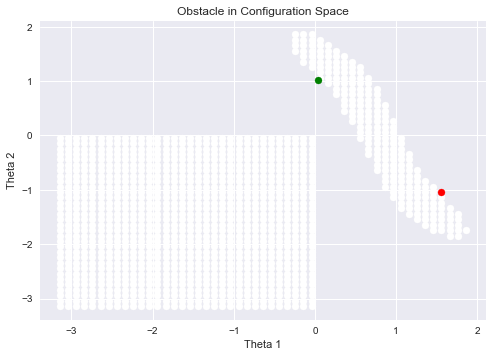

In [4]:
plt.figure(1)
plt.style.use('seaborn')
plt.title("Obstacle in Configuration Space")
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')

for i in range(0, cf_rows):
    for j in range(0, cf_cols):
        if cf_grid[i,j] == -1:
            x_cood = i*cf_precision-cf_bias[0]
            y_cood = j*cf_precision-cf_bias[1]
            plt.scatter(x_cood, y_cood, color='white')

cf_start = ik_two(start, [10,10], [0,0])
cf_end = ik_two(end, [10,10], [0,0])
cf_end = ik_two(end, [10,10], [0,cf_end[1]])

resolved_cf_start = int((cf_start[0]+cf_bias[0])/cf_precision + 1), int((cf_start[1]+cf_bias[1])/cf_precision)
resolved_cf_end = int((cf_end[0]+cf_bias[0])/cf_precision), int((cf_end[1]+cf_bias[1])/cf_precision)
    
plt.scatter(resolved_cf_start[0]*cf_precision - cf_bias[0], resolved_cf_start[1]*cf_precision - cf_bias[1], color="red")
plt.scatter(cf_end[0], cf_end[1], color="green")
    

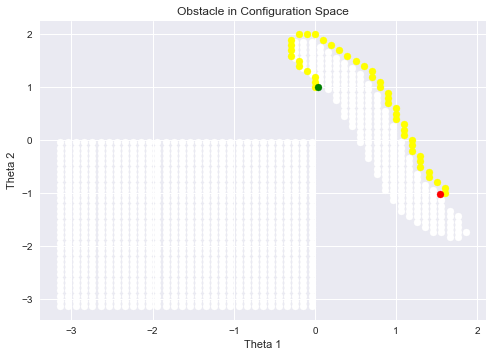

In [5]:
cf_grid[resolved_cf_start] = 7
cf_grid[resolved_cf_end] = 8

cf_path = a_star(resolved_cf_start, resolved_cf_end, cf_grid)

if cf_path is not None:
    for i in cf_path:
        cf_grid[i[0], i[1]] = 9
    cf_grid[resolved_cf_start] = 7
    cf_grid[resolved_cf_end] = 8

cf_path.reverse()


plt.figure(1)
plt.style.use('seaborn')
plt.title("Obstacle in Configuration Space")
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')

for i in range(0, cf_rows):
    for j in range(0, cf_cols):
        if cf_grid[i,j] == -1:
            x_cood = i*cf_precision-cf_bias[0]
            y_cood = j*cf_precision-cf_bias[1]
            plt.scatter(x_cood, y_cood, color='white')

for point in cf_path:
    x_cood = round((point[0])*cf_precision - cf_bias[0],1)
    y_cood = round((point[1])*cf_precision - cf_bias[1],1)
    plt.scatter(x_cood,y_cood, color='yellow')
    
plt.scatter(cf_start[0], cf_start[1], color="red")
plt.scatter(cf_end[0], cf_end[1], color="green")
    

<strong>5) Following the path you computed in #4, what is the path of the end-effector in the workspace.   Create a second plot that shows some sample arm configurations while moving along the path. <strong/>

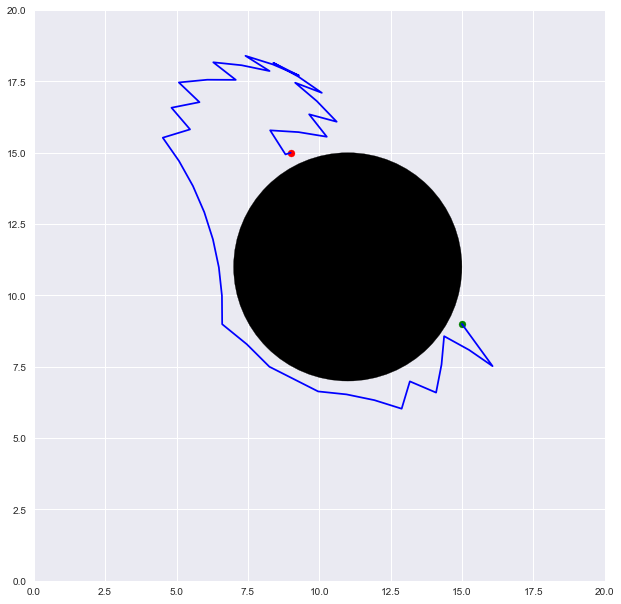

In [6]:
path_workspace = []

path_workspace.append(fk([10,10], [cf_start[0], cf_start[1]]))
for point in cf_path:
    x_cood = point[0]*cf_precision - cf_bias[0]
    y_cood = point[1]*cf_precision - cf_bias[1]
    path_workspace.append(fk([10,10],[x_cood,y_cood]))
    
# del path_workspace[1]
# del path_workspace[-1]

path_workspace.append(fk([10,10], [cf_end[0], cf_end[1]]))

x_path=[]
y_path=[]
obstacle_figs=[]

for x in path_workspace:
    x_path.append(x[0])
    y_path.append(x[1])

fig, ax = plt.subplots()

obstacle_figs.append(plt.Circle(( 11 , 11 ), 4, color='black'))

# plot the path
# for i in range(0, len(x_path)):
#     plt.scatter(x_path[i], y_path[i], color='yellow')
plt.plot(x_path,y_path, color='blue')
plt.scatter(start[0],start[1], color='red') # mark start with red
plt.scatter(end[0],end[1], color='green') # mark end with green

# add obstacles
for x in obstacle_figs:
    ax.add_patch(x)

# set plot parameters
ax.set_xlim((0, 20))
ax.set_ylim((0, 20))
ax.set_aspect(1)
fig.set_size_inches(18.5, 10.5)

plt.show()


The path towards the end shows increased oscillatory behaviour due to my underlying A-star algorithm being used, mainly because my A-star algorith incorporates a diagonal traversal as a composite of two cardinal direciton traversals. I feel, that with this change, or with the utilasation of another path follwing algorithm, the mentioned problem can be overcome.